# Proyecto de Redes Neuronales con PyTorch
### Autores: Over Alexander Mejia Rosado y Ronald Mateo Ceballos Lozano
### Asignatura: Redes Neuronales y Aprendizaje Profundo
Como proyecto de la asignatura Redes Neuronales y Aprendizaje Profundo, se decidio realizar la construcción de una Red Convolucional Neuronal (CNN) que detecte el abecedario en lenguaje de señas americano. Para ello se tomo un dataset de Kaggle con las siguientes caracteristicas:

### Clasificador del Abecedario de Lenguaje de Señas Americano:

- **Cantidad de Datos**: El número de datos es de 87000 con un tamaño de 200x200 pixeles.
- **Cantidad de Clases**: Existen 29 clases de las cuales 26 son para las del abecedario (A-Z) y 3 clases para "Space", "Delete y "Nothing".

Se decidio filtrar las clases del dataset para reducir el tiempo de entrenamiento del modelo y solo analizar las vocales del abecedario y "Nothing" que relaciona a un espacio vacio. Gracias a esto nuestro dataset quedo de la siguiente manera:

- **Cantidad de Datos**: El número de datos es de 18000 con un tamaño de 200x200 pixeles.
- **Cantidad de Clases**: Existen 6 clases de las cuales 5 son para las vocales (A, E, I, O, U) y la ultima clase para "Nothing", cada clase tiene 3000 imagenes.

En el directorio donde se descargaron los archivos se eliminaron de forma manual las clases que no se implementaron.

# Versiones de Python, Numpy, Matplotlib usadas
`Python 3.10.12`
`Pytorch 2.5.1`
`Matplotlib 3.8.0`
`Torchvision 0.20.1`
`Skicit-learn 1.5.2`

## Instalación e Importación de librerias
Antes de empezar, se deben instalar las librerias que se usaran en el cuaderno, y tambien importarlas para usarlas.

In [ ]:
# Instalación de librerias en Python
%pip install matplotlib torch torchvision scikit-learn
%pip install kaggle
%kaggle datasets download grassknoted/asl-alphabet -p /content/data --unzip #Dataset de Kaggle con el alfabeto en lenguaje de señas

UsageError: Line magic function `%kaggle` not found.


A continuación importamos las librerias para poder usarlas y realizamos una verificación para utilizar las dependencias de CUDA con una tarjeta grafica NVIDIA y acelerar el procesamiento de la red. Si no contamos con una tarjeta grafica NVIDIA, por defecto el tomara el CPU del computador.

In [1]:
# Importación de librerias
#import kagglehub as kh
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Comprobación de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo usado: {device}")

Dispositivo usado: cpu


## Carga y Preparación de los datos
Para crear el modelo y entrenarlo, se utilizarán los datos del dataset con las vocales en lenguaje de señas americano filtrados, es decir los 18000 datos correspondientes a las vocales y al espacio vacio. Se realiza una redimensión de `200x200` a `32x32` y disminuir la complejidad del modelo.

In [2]:
# Definir la transformación de redimensionamiento
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Redimensionar a 32x32 píxeles
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalización de los datos
])

# Aplicar la transformación al crear el dataset
dataset = datasets.ImageFolder(root='data/asl_alphabet_train/asl_alphabet_train', transform=transform)

## Verificación del Dataset
Realizamos la verificación de nuestro `Dataset`.

In [3]:
dataset

Dataset ImageFolder
    Number of datapoints: 18000
    Root location: data/asl_alphabet_train/asl_alphabet_train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

## División el Conjunto del Entrenamiento y Validación
Teniendo en cuenta el número de datos de nuestro nuevo `Dataset Filtrado`, dividimos nuestros datos de `Entrenamiento` y `Validación`

In [4]:
# Dividir en conjuntos de entrenamiento y validación
train_dataset, val_dataset = random_split(dataset, [12000, 6000])

## DataLoaders para manejar los datos en mini-batches
Asignamos el tamaño de los datos en los mini-batches o lotes de entrenamiento


In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # batch = lote
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Visualización de los datos
Para conocer las imagenes de nuestro `Dataset Filtrado`, se imprimen 5 imagenes con su etiqueta correspondiente.

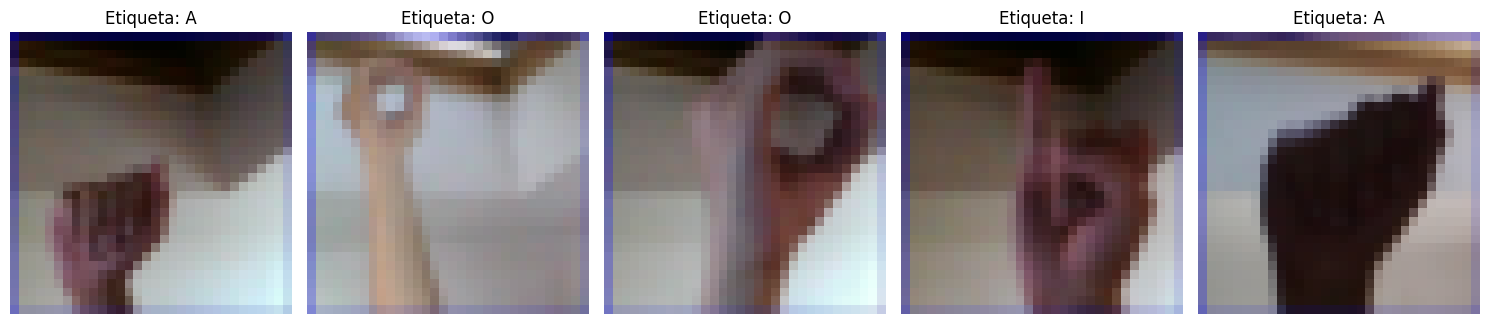

In [7]:
def visualize_asl(loader, dataset, n_images=5):
    """
    Muestra un conjunto de imágenes con sus etiquetas desde el DataLoader.

    Args:
        loader (DataLoader): DataLoader que contiene el dataset de señas.
        dataset (ImageFolder): El dataset original de ImageFolder.
        n_images (int): Número de imágenes a mostrar.
    """
    # Obtener las clases del dataset original
    classes = dataset.classes # Access classes from the original dataset

    # Obtener un batch del DataLoader
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Seleccionar las primeras n imágenes
    images = images[:n_images]
    labels = labels[:n_images]

    # Configurar la cuadrícula de la visualización
    fig, axes = plt.subplots(1, n_images, figsize=(15, 15))
    for i in range(n_images):
        img = images[i].permute(1, 2, 0).numpy()
        # Reescalar los valores de -1 a 1 para el rango 0 a 1
        img = (img * 0.5) + 0.5
        axes[i].imshow(img)
        class_name = classes[labels[i].item()]
        axes[i].set_title(f"Etiqueta: {class_name}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Visualización de ejemplos del DataLoader de entrenamiento, passing the original dataset
visualize_asl(train_loader, dataset, n_images=5)  # Usamos la función adaptada

## Arquitectura del Modelo - Red Convolucional Neuronal (CNN)
Para la construcción de la arquitectura de la red convolucional neuronal, se tomaron en cuenta el número de capas convolucionales, capas ocultas y el número de neuronas.

1. **Definición de la clase CNN**:
   - Se define la clase `CNN` que hereda de `nn.Module` y se inicializan las capas convolucionales y totalmente conectadas:
     ```python
     class CNN(nn.Module):
         def __init__(self, input_channels=3, num_outputs=10, conv_channels=[16, 32],
                      kernel_size=3, pool_kernel_size=2, hidden_sizes=[256, 128]):
             super(CNN, self).__init__()
             # Primera capa convolucional
             self.conv1 = nn.Conv2d(input_channels, conv_channels[0], kernel_size=kernel_size, padding=1)
             self.relu1 = nn.ReLU()
             self.pool1 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2)

             # Segunda capa convolucional
             self.conv2 = nn.Conv2d(conv_channels[0], conv_channels[1], kernel_size=kernel_size, padding=1)
             self.relu2 = nn.ReLU()
             self.pool2 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2)

             # Calcular el tamaño de la entrada para la primera capa totalmente conectada
             fc_input_size = conv_channels[1] * (32 // (pool_kernel_size ** 2)) * (32 // (pool_kernel_size ** 2))

             # Capas totalmente conectadas
             self.fc1 = nn.Linear(fc_input_size, hidden_sizes[0])
             self.relu3 = nn.ReLU()
             self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
             self.relu4 = nn.ReLU()
             self.fc3 = nn.Linear(hidden_sizes[1], num_outputs)

         def forward(self, x):
             x = self.pool1(self.relu1(self.conv1(x)))  # Primera capa convolucional + activación + pooling
             x = self.pool2(self.relu2(self.conv2(x)))  # Segunda capa convolucional + activación + pooling
             x = x.view(x.size(0), -1)                 # Aplanar para las capas fc
             x = self.relu3(self.fc1(x))               # Primera capa totalmente conectada + activación
             x = self.relu4(self.fc2(x))               # Segunda capa totalmente conectada + activación
             x = self.fc3(x)                           # Capa de salida
             return x
     ```

2. **Definir hiperparámetros**:
   - Se definen los hiperparámetros para la red neuronal:
     ```python
     input_channels = 3  # ASL tiene imágenes RGB
     num_outputs = 6    # Número de clases de salida
     conv_channels = [16, 32]  # Canales en las capas convolucionales
     kernel_size = 3            # Tamaño del kernel
     pool_kernel_size = 2       # Tamaño del kernel para MaxPooling
     hidden_sizes = [128, 64]  # Tamaños de las capas totalmente conectadas
     ```

3. **Crear el modelo**:
   - Se crea una instancia del modelo `CNN` y se mueve al dispositivo adecuado (CPU o GPU):
     ```python
     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     model = CNN(input_channels, num_outputs, conv_channels, kernel_size, pool_kernel_size, hidden_sizes).to(device)
     ```

4. **Mostrar la arquitectura del modelo**:
   - Se imprime la arquitectura del modelo para verificar su estructura:
     ```python
     print(model)
     ```

#### Salida esperada:
   - La salida esperada es la impresión de la arquitectura del modelo `CNN`, mostrando las capas convolucionales, las capas de activación, las capas de pooling y las capas totalmente conectadas.

In [6]:
class CNN(nn.Module):
    def __init__(self, input_channels=3, num_outputs=6, conv_channels=[16, 32],
                 kernel_size=3, pool_kernel_size=2, hidden_sizes=[256, 128]):
        super(CNN, self).__init__()
        # Primera capa convolucional
        self.conv1 = nn.Conv2d(input_channels, conv_channels[0], kernel_size=kernel_size, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2)

        # Segunda capa convolucional
        self.conv2 = nn.Conv2d(conv_channels[0], conv_channels[1], kernel_size=kernel_size, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2)

        # Calcular el tamaño de la entrada para la primera capa totalmente conectada
        fc_input_size = conv_channels[1] * (32 // (pool_kernel_size ** 2)) * (32 // (pool_kernel_size ** 2))

        # Capas totalmente conectadas
        self.fc1 = nn.Linear(fc_input_size, hidden_sizes[0])
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], num_outputs)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))  # Primera capa convolucional + activación + pooling
        x = self.pool2(self.relu2(self.conv2(x)))  # Segunda capa convolucional + activación + pooling
        x = x.view(x.size(0), -1)                 # Aplanar para las capas fc
        x = self.relu3(self.fc1(x))               # Primera capa totalmente conectada + activación
        x = self.relu4(self.fc2(x))               # Segunda capa totalmente conectada + activación
        x = self.fc3(x)                           # Capa de salida
        return x

# Definir hiperparámetros
input_channels = 3  # ASL tiene imágenes RGB
num_outputs = 6    # Tamaño de las salidas, 10 imagenes
conv_channels = [16, 32]  # Canales en las capas convolucionales
kernel_size = 3            # Tamaño del kernel
pool_kernel_size = 2       # Tamaño del kernel para MaxPooling
hidden_sizes = [32, 16]  # Tamaños de las capas FC

# Crear el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(input_channels, num_outputs, conv_channels, kernel_size, pool_kernel_size, hidden_sizes).to(device)

# Mostrar la arquitectura del modelo
print(model)


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=32, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=16, out_features=6, bias=True)
)


## ¿Cuántos parámetros tiene nuestra red?
Calculamos el número de parámetros que posee nuestra Red Convolucional Neuronal (CNN) y ver la complejidad de nuestro modelo.

In [10]:
# Cálculo del número total de parámetros
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"El modelo tiene un total de {total_params:,} parámetros entrenables.")

count_parameters(model)

El modelo tiene un total de 71,286 parámetros entrenables.


## Funciones de Pérdida y Optimizador
Definimos nuestra función de perdida para realizar el ajuste de los parámetros utilizando `Backpropagation` y nuestra función de optimización para ajustar la tasa de aprendizaje de nuestra red.

In [7]:
# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Optimizador
optimizer = optim.SGD(model.parameters(), lr=0.05) # Ratio de aprendizaje del 0.05

## Creación del Dataset con los datos propios

In [8]:
# Definir la transformación de redimensionamiento
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Redimensionar a 32x32 píxeles
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Aplicar la transformación al crear el dataset
dataset_propio = datasets.ImageFolder(root='imagenes', transform=transform)

## Verificar el tamaño del Dataset Propio

In [9]:
print(len(dataset_propio))

2100


## Creación de Batch para nuestros Datos Propios

In [10]:
val_propio = DataLoader(dataset_propio, batch_size=64, shuffle=True)

## Visualización de los Datos Propios
Para conocer las imagenes de nuestro `Dataset Propio`, se imprimen 5 imagenes con su etiqueta correspondiente.

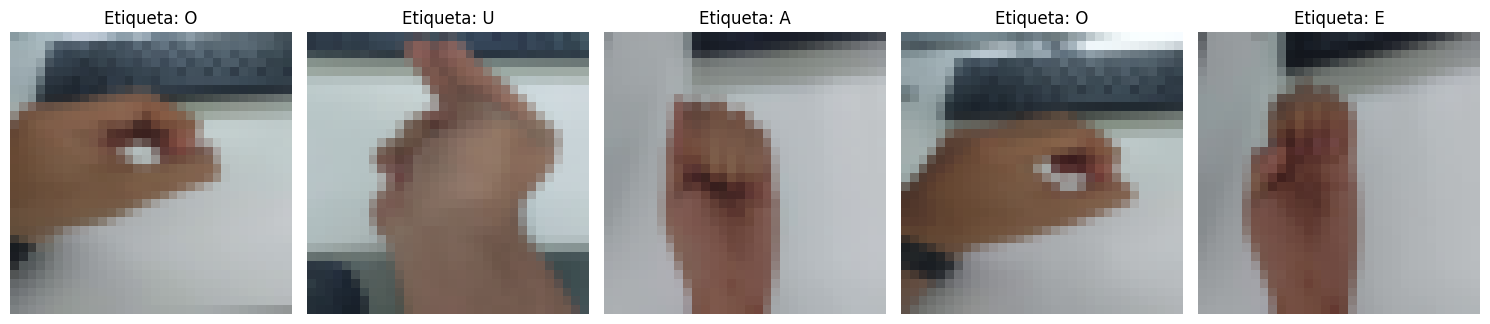

In [13]:
def visualize_asl(val_propio, dataset_propio, n_images=5):
    """
    Muestra un conjunto de imágenes con sus etiquetas desde el DataLoader.

    Args:
        loader (DataLoader): DataLoader que contiene el dataset de señas.
        dataset (ImageFolder): El dataset original de ImageFolder.
        n_images (int): Número de imágenes a mostrar.
    """
    # Obtener las clases del dataset original
    classes = dataset_propio.classes # Access classes from the original dataset

    # Obtener un batch del DataLoader
    data_iter = iter(val_propio)
    images, labels = next(data_iter)

    # Seleccionar las primeras n imágenes
    images = images[:n_images]
    labels = labels[:n_images]

    # Configurar la cuadrícula de la visualización
    fig, axes = plt.subplots(1, n_images, figsize=(15, 15))
    for i in range(n_images):
        img = images[i].permute(1, 2, 0).numpy()
        # Reescalar los valores de -1 a 1 para el rango 0 a 1
        img = (img * 0.5) + 0.5
        axes[i].imshow(img)
        class_name = classes[labels[i].item()]
        axes[i].set_title(f"Etiqueta: {class_name}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Visualización de ejemplos del DataLoader de entrenamiento, passing the original dataset
visualize_asl(val_propio, dataset_propio, n_images=5)  # Usamos la función adaptada

## Ciclo de Entrenamiento y Validación
Se realiza un ciclo de entranmiento y validación con el Dataset de entrenamiento, además se valida el modelo con nuestros propio y asi analizar su comportamiento en cada epoca. Se calculan y almacenan métricas como la pérdida, precisión, recall y F1-Score para cada época.

**Conceptos clave**:
   - **Época**: Una pasada completa a través del conjunto de datos de entrenamiento.
   - **Batch o lote**: Un subconjunto del conjunto de datos de entrenamiento utilizado para actualizar los pesos del modelo.
   - **Propagación hacia adelante**: El proceso de pasar los datos de entrada a través de la red para obtener una predicción.
   - **Propagación hacia atrás**: El proceso de calcular los gradientes y actualizar los pesos del modelo.

In [11]:
# Conceptos clave: época, batch o lote, propagación hacia adelante y hacia atrás
# Ciclo de entrenamiento y validación
epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_recalls = []
val_recalls = []
train_f1_scores = []
val_f1_scores = []
val_losses_propios = []
val_accuracies_propios = []
val_recalls_propios = []
val_f1_scores_propios = []
best_val_accuracy = 0
best_model_weights = None
best_epoch = 0
#val_accuracy = 0

for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()  # Modo entrenamiento
    train_loss = 0
    correct_train = 0
    total_train = 0
    all_targets_train = []  # Lista para etiquetas reales de entrenamiento
    all_predicted_train = [] # Lista para predicciones de entrenamiento

    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.to(device)  # Mover las imágenes al dispositivo (GPU o CPU)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)  # Pasar las imágenes sin aplanar
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumular la pérdida
        train_loss += loss.item()

        # Calcular la precisión
        _, predicted = torch.max(outputs, 1)  # Predicción más probable
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

        # Agregar etiquetas y predicciones de entrenamiento a las listas
        all_targets_train.extend(targets.cpu().numpy())
        all_predicted_train.extend(predicted.cpu().numpy())

    train_losses.append(train_loss / len(train_loader))
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Calcular Recall y F1-Score para entrenamiento
    train_recall = recall_score(all_targets_train, all_predicted_train, average='macro')
    train_f1 = f1_score(all_targets_train, all_predicted_train, average='macro')

    # Almacenar Recall y F1-Score de entrenamiento
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)

    # --- Validación Test ---
    model.eval()  # Modo evaluación
    val_loss = 0
    correct_val = 0
    total_val = 0
    all_targets = []  # Para almacenar todas las etiquetas reales
    all_predicted = [] # Para almacenar todas las predicciones

    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)  # Mover las imágenes al dispositivo (GPU o CPU)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs) # Pasar las imágenes sin aplanar
            loss = criterion(outputs, targets)

            # Acumular la pérdida
            val_loss += loss.item()

            # Calcular la precisión
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

            all_targets.extend(targets.cpu().numpy())  # Agregar etiquetas reales
            all_predicted.extend(predicted.cpu().numpy())  # Agregar predicciones

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Guardar los pesos del mejor modelo basado en la precisión de validación
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()
        best_epoch=epoch+1

    # Calcular Recall y F1-Score
    recall = recall_score(all_targets, all_predicted, average='macro')
    f1 = f1_score(all_targets, all_predicted, average='macro')

    # Almacenar Recall y F1-Score para la época actual
    val_recalls.append(recall)
    val_f1_scores.append(f1)

    # --- Validación Datos Propios ---
    model.eval()  # Modo evaluación
    val_loss_propio = 0
    correct_val_propio = 0
    total_val_propio = 0
    all_targets_propio = []  # Para almacenar todas las etiquetas reales
    all_predicted_propio = [] # Para almacenar todas las predicciones

    with torch.no_grad():
        for batch in val_propio:
            inputs, targets = batch
            inputs = inputs.to(device)  # Mover las imágenes al dispositivo (GPU o CPU)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs) # Pasar las imágenes sin aplanar
            loss = criterion(outputs, targets)

            # Acumular la pérdida
            val_loss_propio += loss.item()

            # Calcular la precisión
            _, predicted = torch.max(outputs, 1)
            correct_val_propio += (predicted == targets).sum().item()
            total_val_propio += targets.size(0)

            all_targets_propio.extend(targets.cpu().numpy())  # Agregar etiquetas reales
            all_predicted_propio.extend(predicted.cpu().numpy())  # Agregar predicciones

    val_losses_propios.append(val_loss_propio / len(val_propio)) # Usar val_loss_propio
    val_accuracy_propio = 100 * correct_val_propio / total_val_propio # Usar correct_val_propio, total_val_propio
    val_accuracies_propios.append(val_accuracy_propio)           # Usar val_accuracy_propio

    # Calcular Recall y F1-Score
    recall_propio = recall_score(all_targets_propio, all_predicted_propio, average='macro')
    f1_propio = f1_score(all_targets_propio, all_predicted_propio, average='macro')

    # Almacenar Recall y F1-Score para la época actual
    val_recalls_propios.append(recall_propio)
    val_f1_scores_propios.append(f1_propio)

    # --- Imprimir resultados por época ---
    print(f"Época {epoch + 1}/{epochs}")
    print(f"  Entrenamiento -> Pérdida: {train_losses[-1]:.4f}, Precisión: {train_accuracy:.2f}%, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}")  # Incluir métricas de entrenamiento
    print(f"  Validación   -> Pérdida: {val_losses[-1]:.4f}, Precisión: {val_accuracy:.2f}%, Recall: {recall:.4f}, F1-Score: {f1:.4f}") # Métricas de Validación
    print(f"  Validación Propia  -> Pérdida: {val_losses_propios[-1]:.4f}, Precisión: {val_accuracy_propio:.2f}%, Recall: {recall_propio:.4f}, F1-Score: {f1_propio:.4f}") # Métricas de Validación del Dataset Propio

model = CNN(input_channels, num_outputs, conv_channels, kernel_size, pool_kernel_size, hidden_sizes).to(device)
model.load_state_dict(best_model_weights)
print(f"Mejor modelo en la época {best_epoch} con precisión de validación: {best_val_accuracy:.2f}%")

Época 1/10
  Entrenamiento -> Pérdida: 1.7211, Precisión: 26.96%, Recall: 0.2698, F1-Score: 0.2565
  Validación   -> Pérdida: 1.4024, Precisión: 44.65%, Recall: 0.4479, F1-Score: 0.3964
  Validación Propia  -> Pérdida: 1.8522, Precisión: 25.24%, Recall: 0.2524, F1-Score: 0.2069
Época 2/10
  Entrenamiento -> Pérdida: 1.1760, Precisión: 49.52%, Recall: 0.4956, F1-Score: 0.4883
  Validación   -> Pérdida: 0.9671, Precisión: 52.97%, Recall: 0.5306, F1-Score: 0.4463
  Validación Propia  -> Pérdida: 1.7999, Precisión: 44.43%, Recall: 0.4443, F1-Score: 0.3842
Época 3/10
  Entrenamiento -> Pérdida: 0.8946, Precisión: 62.13%, Recall: 0.6220, F1-Score: 0.6189
  Validación   -> Pérdida: 0.8206, Precisión: 62.43%, Recall: 0.6226, F1-Score: 0.6083
  Validación Propia  -> Pérdida: 1.7951, Precisión: 28.00%, Recall: 0.2800, F1-Score: 0.2424
Época 4/10
  Entrenamiento -> Pérdida: 0.7284, Precisión: 69.21%, Recall: 0.6927, F1-Score: 0.6909
  Validación   -> Pérdida: 0.6768, Precisión: 69.90%, Recall: 0.

## Configuración de los hiperparámetros
Teniendo en cuenta nuestro modelo, y luego de realizar pruebas con diferentes hiperparámetros como el número de epocas, el learning rate y número de neuronas en las capas ocultas, se definieron los siguientes hiperparámetros:

## **Hiperparámetros Elegidos**
- **Número de Epocas**: 10 epocas.
- **Learning Rate**: 0.05.
- **Número de Neuronas en las Capas Ocultas**: (32,16).

A continuación se muestran las pruebas realizadas para la selección de los mejores hiperparámetros en nuestro modelo.

### **Número de Epocas**

#### **10 Epocas**
En la prueba con 10 epocas, se logro un gran porcentaje de precisión cerca del 90%, por lo que nuestro modelo tiene una buena precisión, y esto se evidencia las siguientes curvas de perdidas y precisión con 10 epocas.

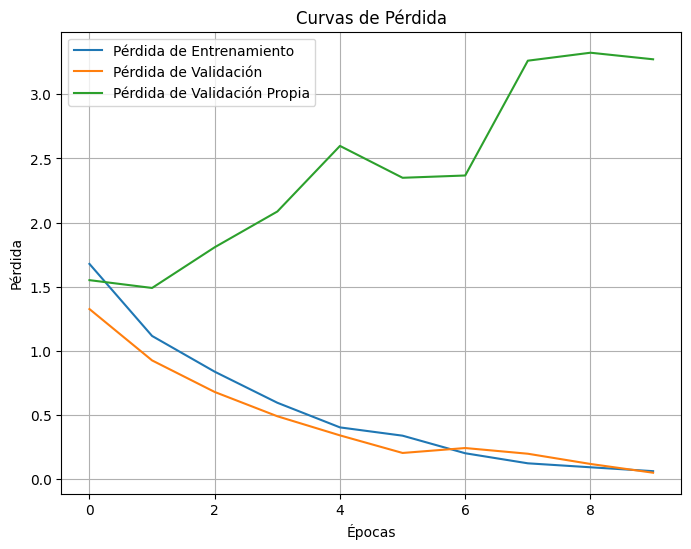
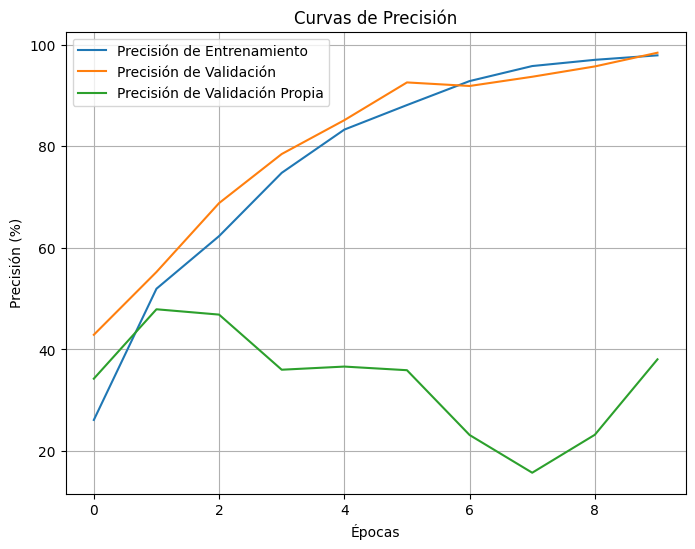

#### **20 Epocas**
En la prueba con 20 epocas, se logro un gran porcentaje de precisión a 10 epocas, por lo que con 20 epocas se puede presentar un sobreentrenamiento en los datos, y esto se evidencia las siguientes curvas de perdidas y precisión con 20 epocas.

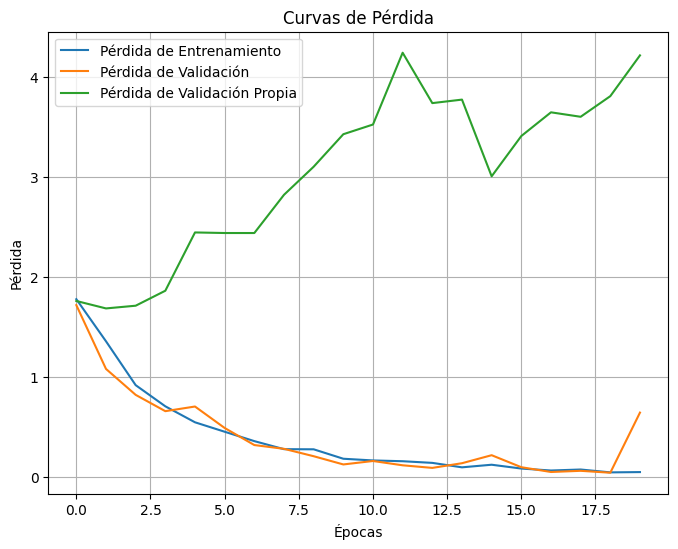
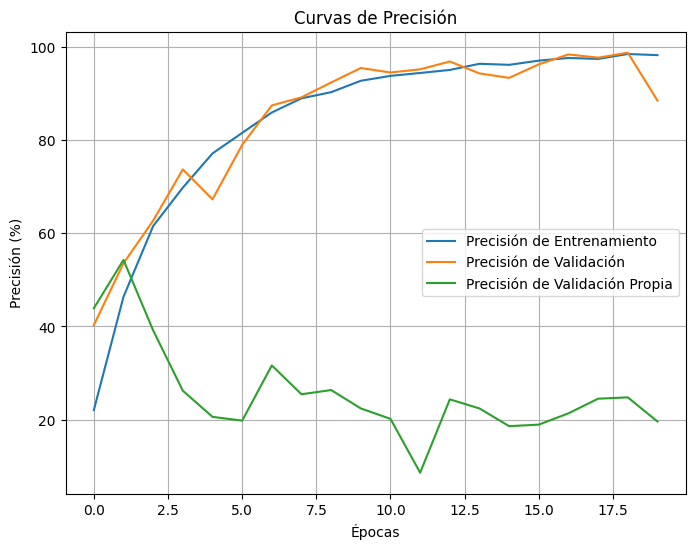

#### **30 Epocas**
En la prueba con 30 epocas, al igual que con el entrenamiento de 20 epocas, a las 10 epocas el modelo obtuvo un buen porcentaje de precisión, sin embargo, se nota el sobreentrenamiento en los datos debido a las fluctuaciones que sufre la curva de entrenamiento y validaciones que se muestran a continuación.

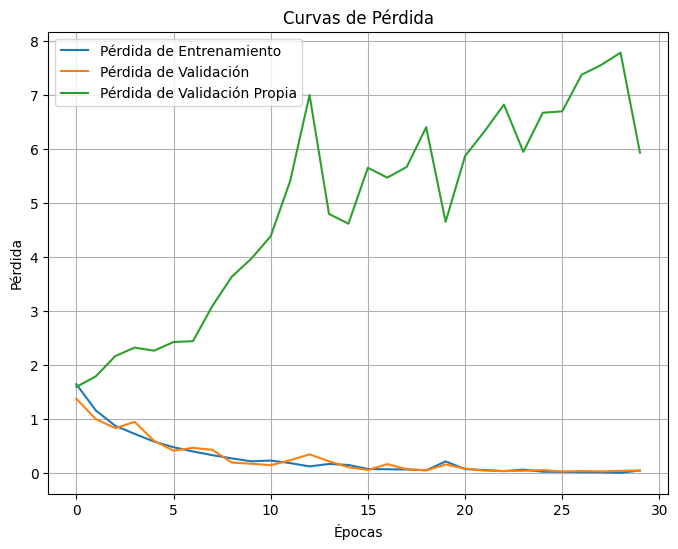
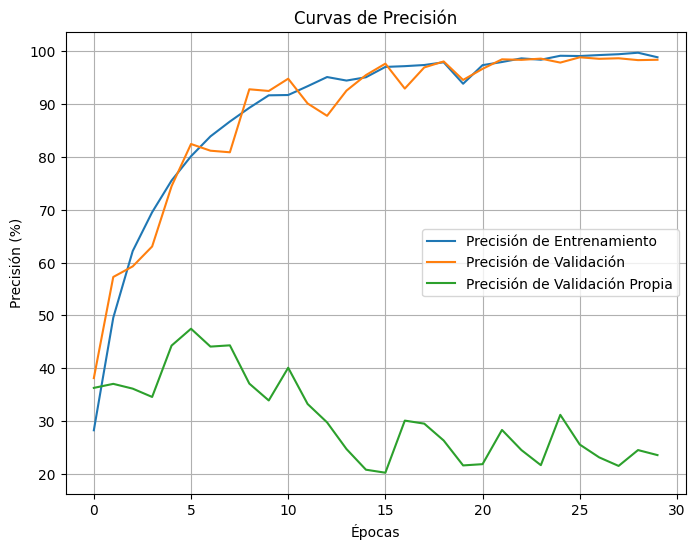

### **Learning Rate**

#### **Learning Rate: 0.05**
El learning rate optimo fue del 0.05, que permite al modelo aprender rapido pero sin afectar negativamente la precisión del modelo en los datos de validación en los datos propios. Esto se puede ver a continuación en el entrenamiento con learning rate 0.05 y 10 epocas.

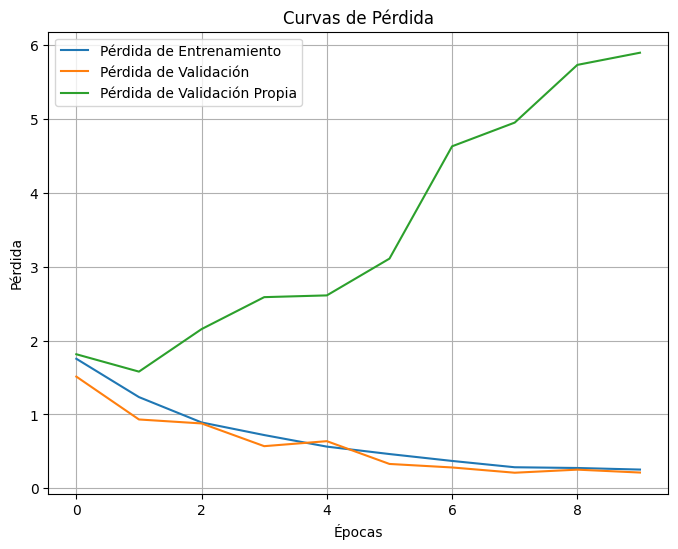
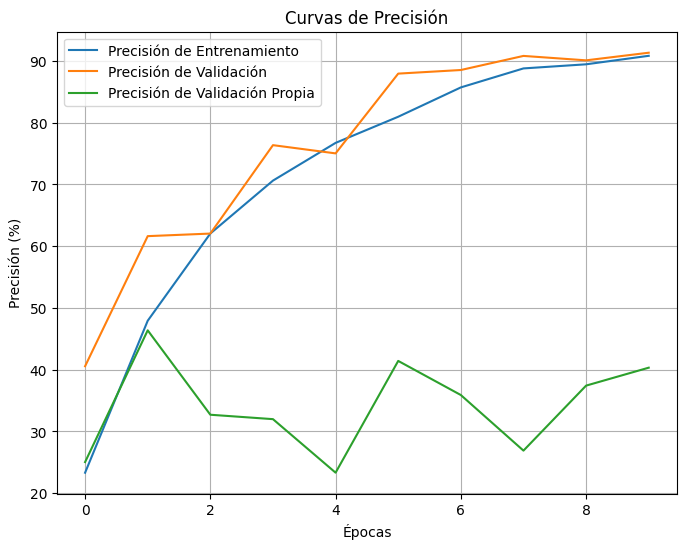

#### **Learning Rate: 0.08**
El learning rate de 0.08, disminuyo la precisión de validación con los datos propios del modelo aunque consiguio una buena precisión en su etapa de entrenamiento. Esto se puede ver a continuación en el entrenamiento con learning rate 0.08 y 10 epocas.

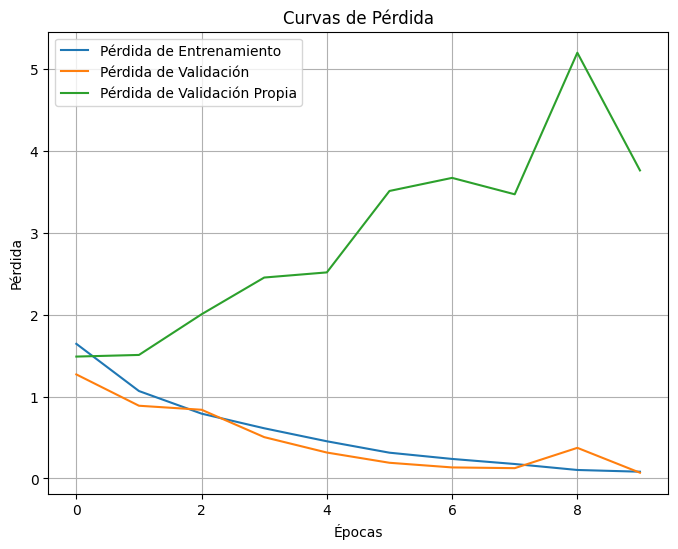
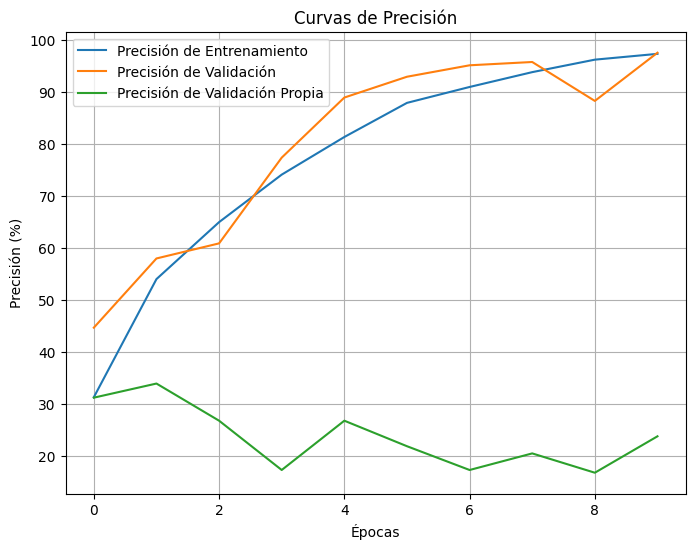

#### **Learning Rate: 0.1**
El learning rate de 0.1, que permitio un aprendizaje más rapido que los demás learning rates, obtuvo una buena precisión en el modelo, sin embargo, puede perder algunas caracteristicas en los datos al momento de validar el modelo con los datos de validación. Esto se puede ver a continuación en el siguiente entrenamiento con 10 epocas.

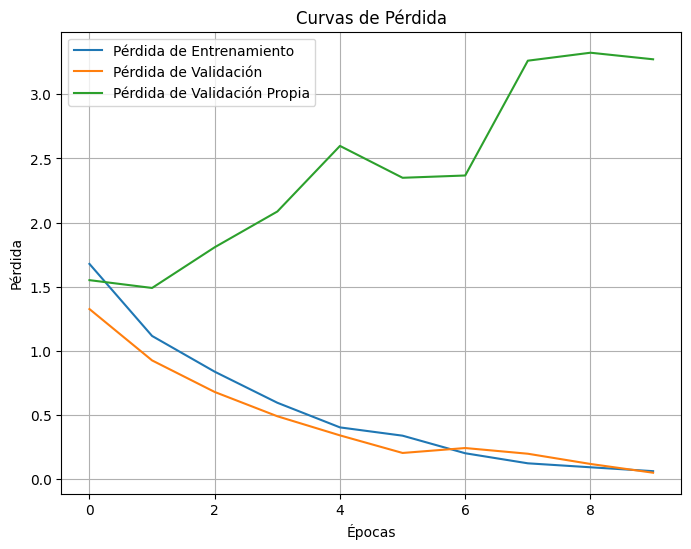
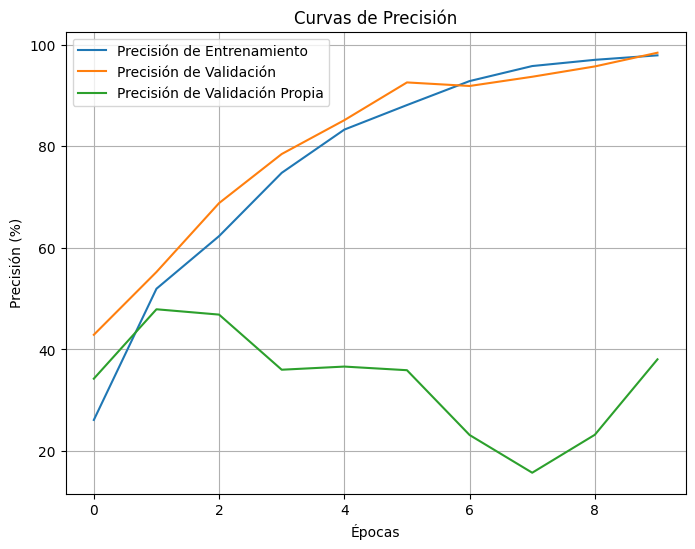

### **Número de Neuronas en Capas Ocultas**

#### **Neuronas en capas ocultas (32, 16)**
El módelo con este número de neuronas es el menos complejo, el que toma menos tiempo de entrenamiento y presenta 71,286 parámetros con el nivel más alto en la validación con nuestros datos propios. Esto se evidencia en las siguientes curvas de entrenamiento y validación.

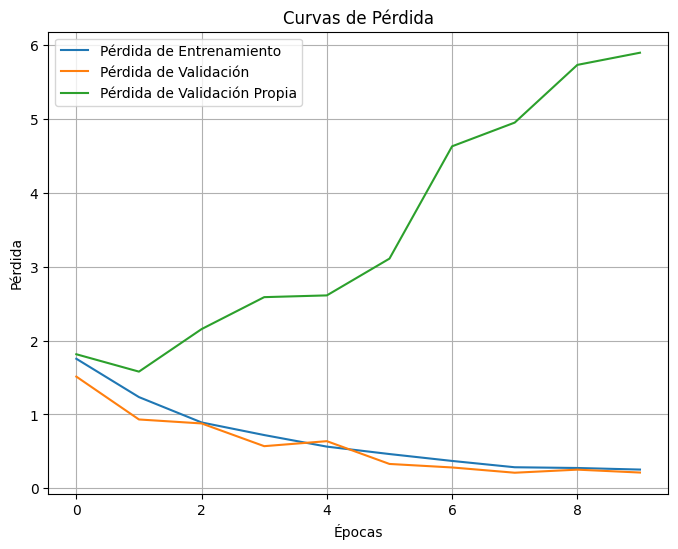
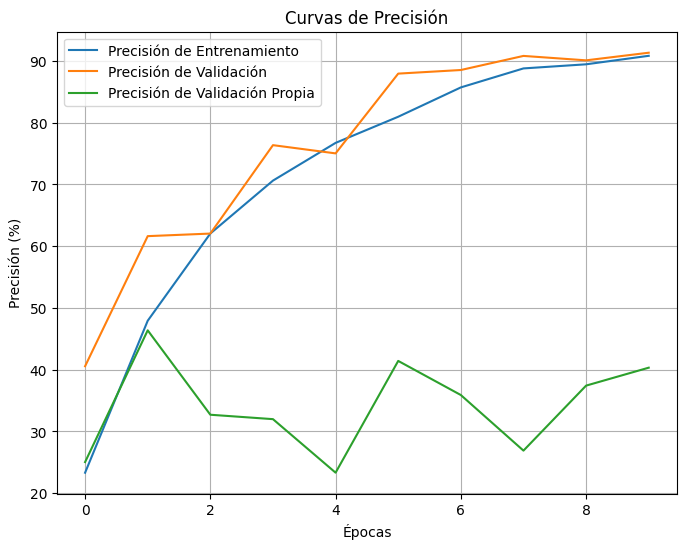

#### **Neuronas en capas ocultas (64, 32)**
El módelo con este número de neuronas es un poco más complejo que el anterior y tiene 138,502 parámetros, tomo un mayor tiempo en el entrenamiento y obtuvo menor número de precisión en la validación con los datos propios. A continuación se muestran las curvas del entrenamiento y validación con este modelo.

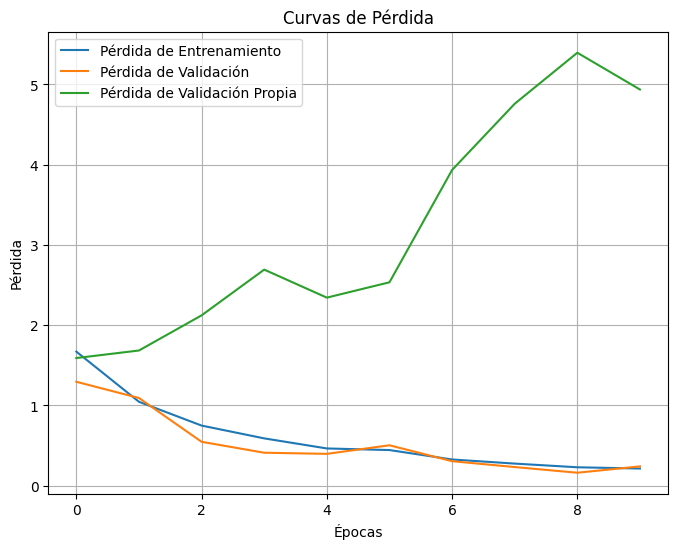
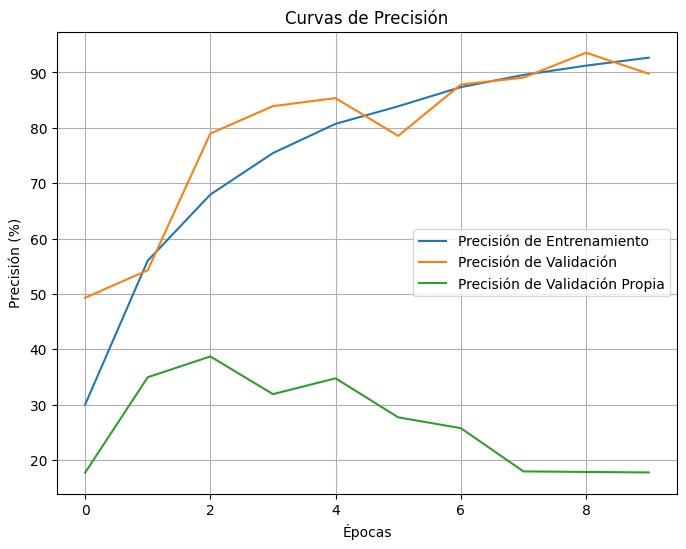
#### **Neuronas en capas ocultas (128, 64)**
El módelo con este número de neuronas es el más complejo de todos, tomo demasiado tiempo en el entrenamiento, tiene 276,006 parámetros y no obtuvo mejora en su entrenamiento, por lo que fue descartado. Se evidencia este modelo con las curvas a continuación. 

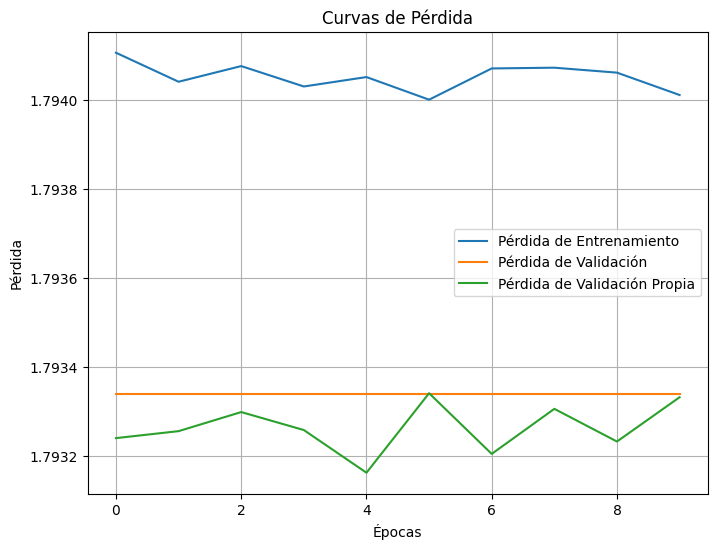
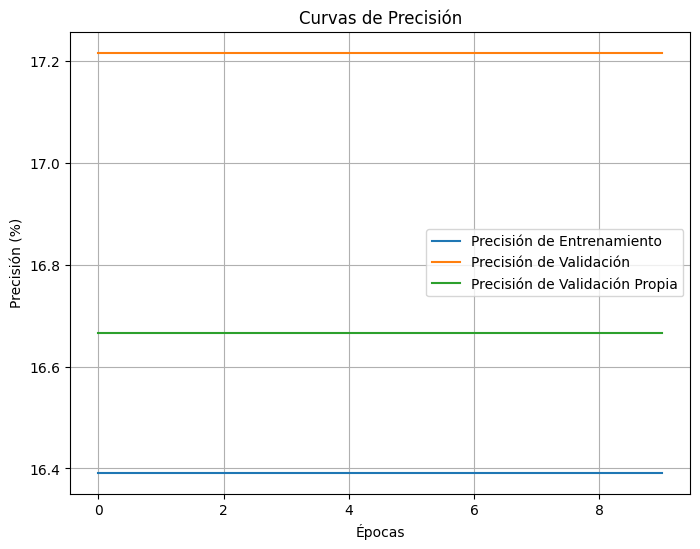

## Grafiquemos la función de pérdida
Para visualizar de mejor forma las métricas y rendimiento de nuestro modelo en los entrenamientos y validaciones, se grafican de manera conjunta.

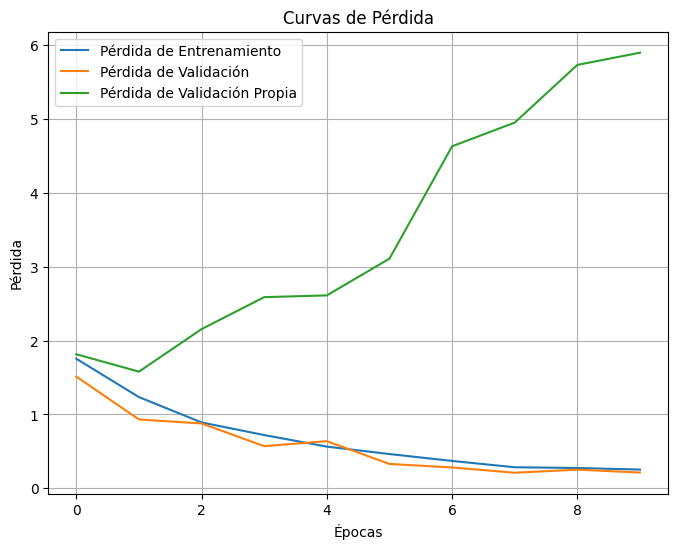

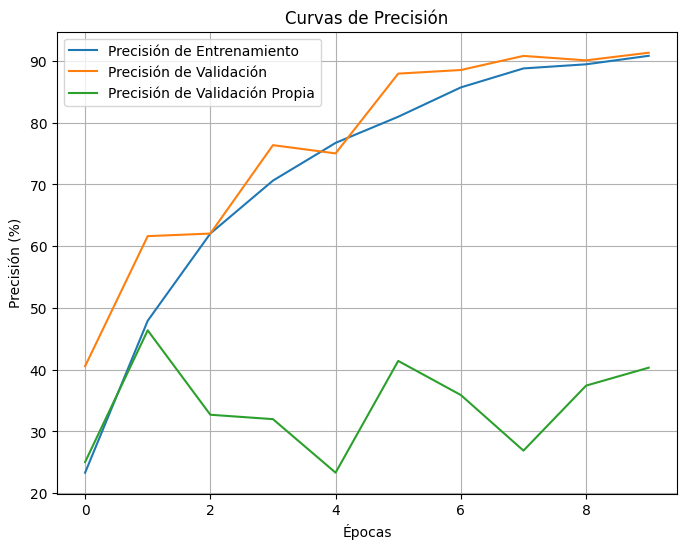

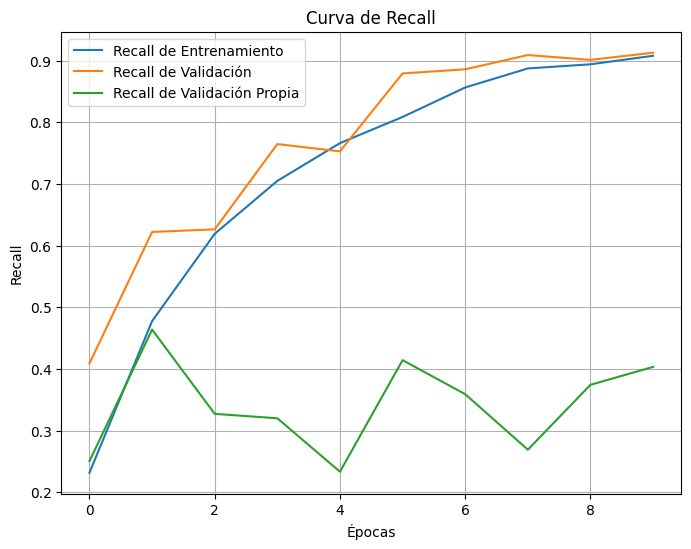

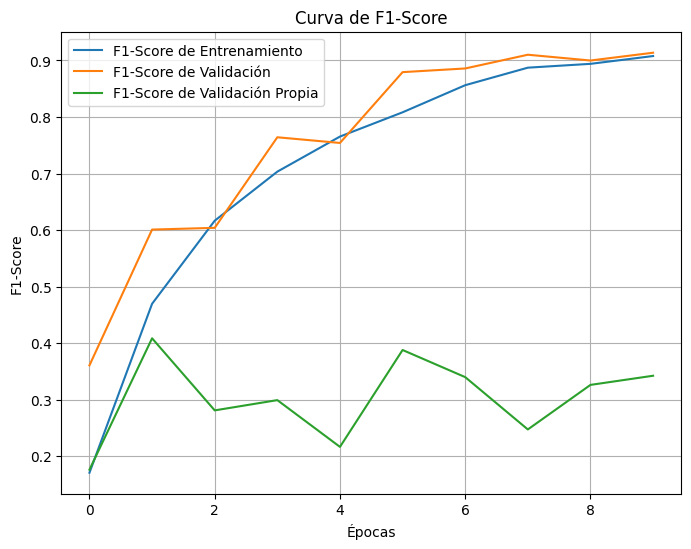

In [ ]:
# Gráfica de la pérdida
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(val_losses, label='Pérdida de Validación')
plt.plot(val_losses_propios, label='Pérdida de Validación Propia')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curvas de Pérdida')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de la precisión
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Precisión de Entrenamiento')
plt.plot(val_accuracies, label='Precisión de Validación')
plt.plot(val_accuracies_propios, label='Precisión de Validación Propia')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.title('Curvas de Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de Recall
plt.figure(figsize=(8, 6))
plt.plot(train_recalls, label='Recall de Entrenamiento')
plt.plot(val_recalls, label='Recall de Validación')
plt.plot(val_recalls_propios, label='Recall de Validación Propia')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.title('Curva de Recall')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de F1-Score
plt.figure(figsize=(8, 6))
plt.plot(train_f1_scores, label='F1-Score de Entrenamiento')
plt.plot(val_f1_scores, label='F1-Score de Validación')
plt.plot(val_f1_scores_propios, label='F1-Score de Validación Propia')
plt.xlabel('Épocas')
plt.ylabel('F1-Score')
plt.title('Curva de F1-Score')
plt.legend()
plt.grid(True)
plt.show()

## Guardar párametros
Se realiza un guardado de los valores de los parámetros del modelo, con el fin de seguir entrenandolos o aplicar validaciones con otros datos.

In [ ]:
# Guardar los pesos del modelo
torch.save(model.state_dict(), "modelo_entrenado.pth")
print("Pesos del modelo guardados en 'modelo_entrenado.pth'")

## Cargar Datos Guardados de los Parametros
El siguiente codigo sobreescribe el modelo con los parámetros anteriormente guardados

In [ ]:
# Crear una nueva instancia del modelo
model = CNN(input_channels, num_outputs, conv_channels, kernel_size, pool_kernel_size, hidden_sizes).to(device)

# Cargar únicamente los pesos del modelo desde un archivo confiable
state_dict = torch.load("modelo_entrenado.pth",weights_only=True)  # map_location=device es opcional para mover a GPU/CPU
model.load_state_dict(state_dict)
model.eval()
print("Pesos del modelo cargados de forma segura desde 'modelo_entrenado.pth'")

## Ejemplo de Predicciónes

Para verificar el funcionamiento de nuestro modelo, validamos con los batchs de validación y calculamos las metricas, cabe resaltar que solo se imprimiran 5 imagenes pertenecientes al batch, sin embargo las métricas son calculadas con el número total del batch, es decir, para calcular la precisión del batch 1, se toman los aciertos de las 64 imagenes correspondientes a ese bacth.

In [62]:
def plot_predictions(model, loader, batch_ith=1):
    model.eval()
    data_iter = iter(loader)
    for i in range(batch_ith):
        inputs, targets = next(data_iter)
    inputs = inputs.to(device)  # No es necesario aplanar las imágenes para ASL
    targets = targets.to(device)

    outputs = model(inputs)  # Pasa las imágenes sin aplanar
    _, predicted = torch.max(outputs, 1)

    # Obtener todas las predicciones y etiquetas reales del lote
    all_predicted = predicted.cpu().numpy()
    all_targets = targets.cpu().numpy()

    # Mapeo de etiquetas a nombres de clases para ASL (29 clases)
    classes = dataset.classes  # Obtén las clases del dataset original

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        img = inputs[i].cpu().permute(1, 2, 0).numpy()
        # Reescalar los valores de -1 a 1 para el rango 0 a 1
        img = (img * 0.5) + 0.5
        axes[i].imshow(img)  # Mostrar imagen en color
        # Obtener nombres de clases para predicción y etiqueta real
        predicted_class = classes[predicted[i].item()]  # Usa las clases del dataset
        true_class = classes[targets[i].item()]  # Usa las clases del dataset
        axes[i].set_title(f"Pred: {predicted_class}\nTrue: {true_class}")
        axes[i].axis("off")
    plt.show()

    # Calcular las métricas
    precision = precision_score(all_targets, all_predicted, average='weighted')
    recall = recall_score(all_targets, all_predicted, average='weighted')
    f1 = f1_score(all_targets, all_predicted, average='weighted')

    # Imprimir las métricas
    print(f"Precisión del bacth: {batch_ith}")
    print(f"Precisión: {100 * precision:.2f} %")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

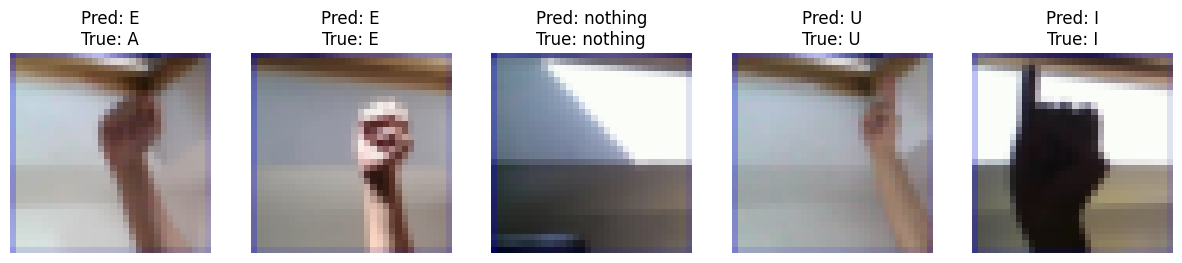

Precisión del bacth: 1
Precisión: 92.48 %
Recall: 0.8906
F1-score: 0.8754


In [36]:
plot_predictions(model, val_loader, batch_ith=1)

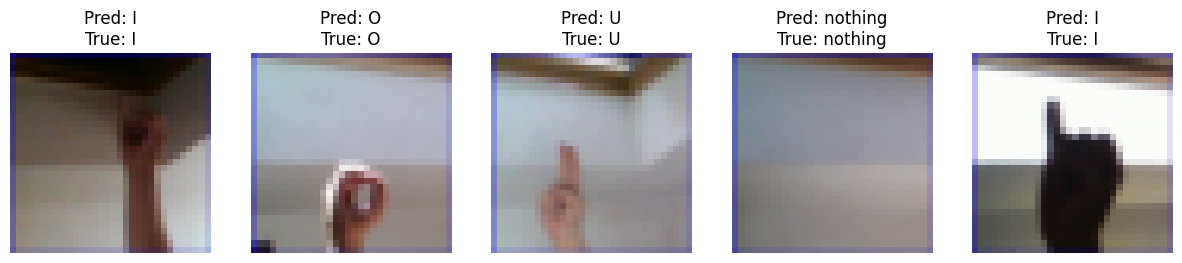

Precisión del bacth: 10
Precisión: 96.04 %
Recall: 0.9531
F1-score: 0.9496


In [37]:
plot_predictions(model, val_loader, batch_ith=10)

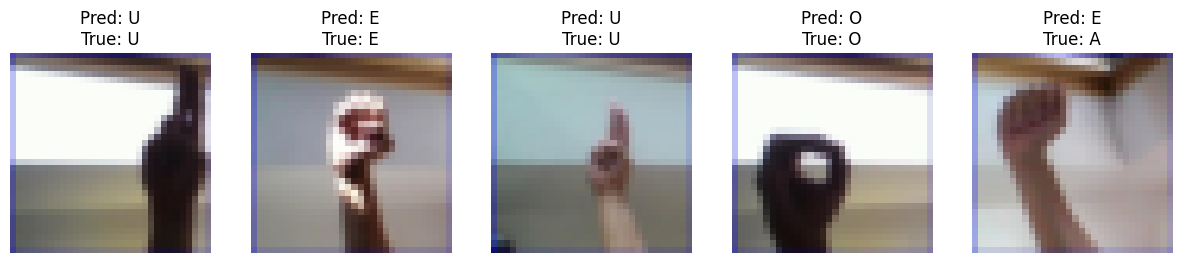

Precisión del bacth: 15
Precisión: 92.06 %
Recall: 0.9062
F1-score: 0.9028


In [39]:
plot_predictions(model, val_loader, batch_ith = 15)

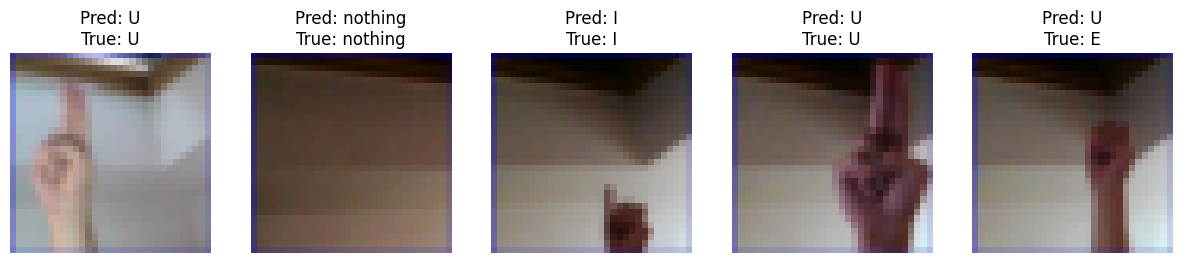

Precisión del bacth: 20
Precisión: 91.35 %
Recall: 0.9062
F1-score: 0.9037


In [40]:
plot_predictions(model, val_loader, batch_ith = 20)

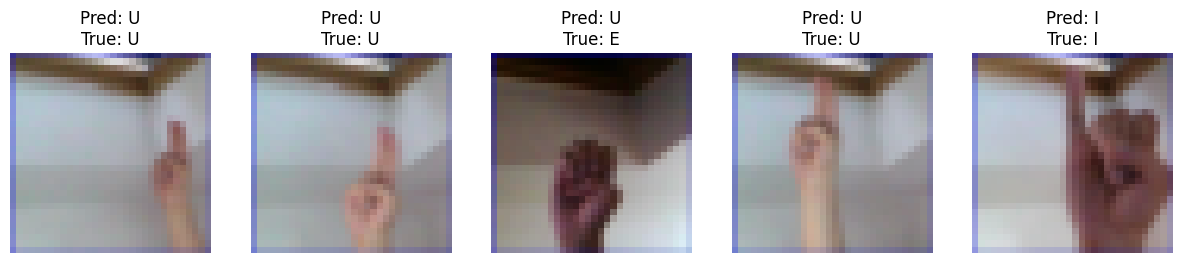

Precisión del bacth: 25
Precisión: 91.26 %
Recall: 0.8906
F1-score: 0.8880


In [42]:
plot_predictions(model, val_loader, batch_ith = 25)

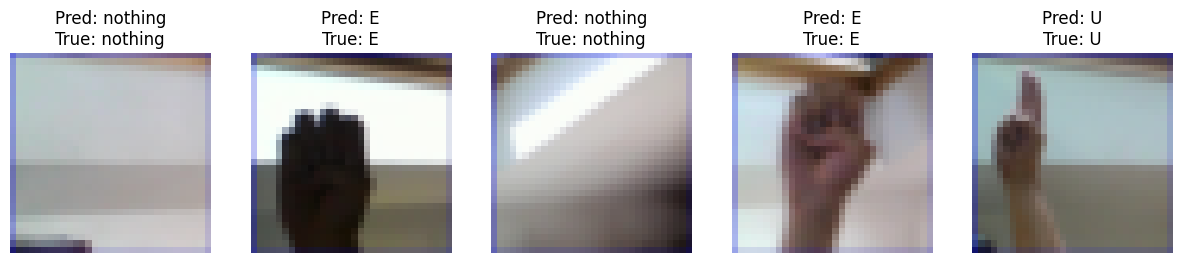

Precisión del bacth: 40
Precisión: 91.55 %
Recall: 0.8906
F1-score: 0.8637


In [43]:
plot_predictions(model, val_loader, batch_ith = 40)

## Validaciones con los Datos Propias
La validación de nuestro modelo con nuestros datos propios, se realiza de la misma forma que con nuestros datos de validacion de entrenamiento, solo cambia el tamaño del batch y el calculo de las métricas que en este caso, se realizaran para las 32 imagenes correspondientes a los batch de validacion de datos propios.

In [82]:
def plot_predictions(model, loader, batch_ith=1):
    model.eval()
    data_iter = iter(loader)
    for i in range(batch_ith):
        inputs, targets = next(data_iter)
    inputs = inputs.to(device)  # No es necesario aplanar las imágenes para ASL
    targets = targets.to(device)

    outputs = model(inputs)  # Pasa las imágenes sin aplanar
    _, predicted = torch.max(outputs, 1)

    # Obtener todas las predicciones y etiquetas reales del lote
    all_predicted = predicted.cpu().numpy()
    all_targets = targets.cpu().numpy()

    # Mapeo de etiquetas a nombres de clases para ASL (29 clases)
    classes = dataset.classes  # Obtén las clases del dataset original
    classes_propio = dataset_propio.classes

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        img = inputs[i].cpu().permute(1, 2, 0).numpy()
        # Reescalar los valores de -1 a 1 para el rango 0 a 1
        img = (img * 0.5) + 0.5
        axes[i].imshow(img)  # Mostrar imagen en color
        # Obtener nombres de clases para predicción y etiqueta real
        predicted_class = classes[predicted[i].item()]  # Usa las clases del dataset
        true_class = classes_propio[targets[i].item()]  # Usa las clases del dataset
        axes[i].set_title(f"Pred: {predicted_class}\nTrue: {true_class}")
        axes[i].axis("off")
    plt.show()

    # Calcular las métricas
    precision = precision_score(all_targets, all_predicted, average='weighted')
    recall = recall_score(all_targets, all_predicted, average='weighted')
    f1 = f1_score(all_targets, all_predicted, average='weighted')

    # Imprimir las métricas
    print(f"Precisión del bacth: {batch_ith}")
    print(f"Precisión: {100 * precision:.2f} %")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

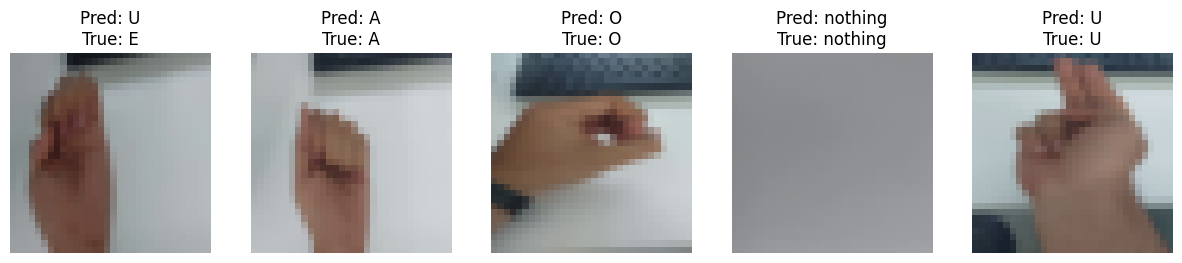

Precisión del bacth: 1
Precisión: 49.40 %
Recall: 0.5156
F1-score: 0.4844


In [64]:
plot_predictions(model, val_propio, batch_ith=1)

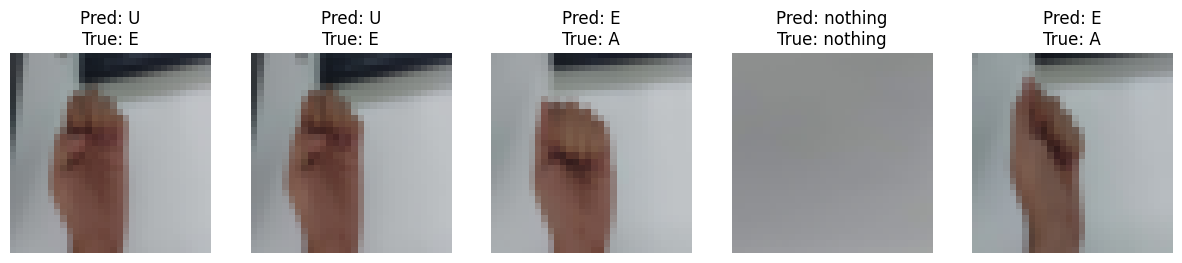

Precisión del bacth: 5
Precisión: 32.00 %
Recall: 0.3594
F1-score: 0.3326


In [66]:
plot_predictions(model, val_propio, batch_ith=5)

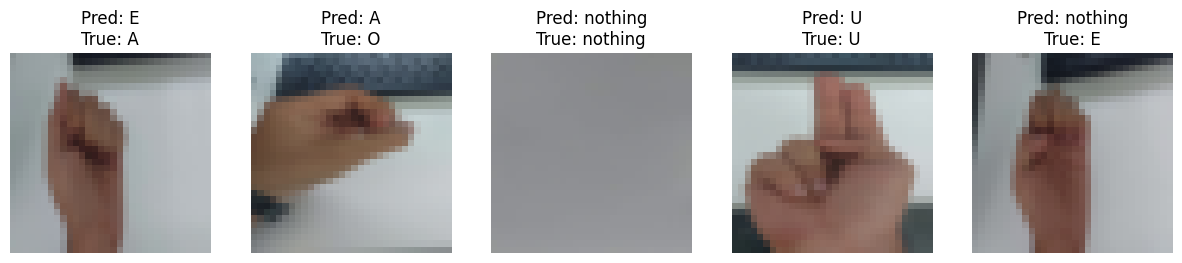

Precisión del bacth: 10
Precisión: 23.71 %
Recall: 0.3438
F1-score: 0.2764


c:\Users\Tommy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [84]:
plot_predictions(model, val_propio, batch_ith=10)

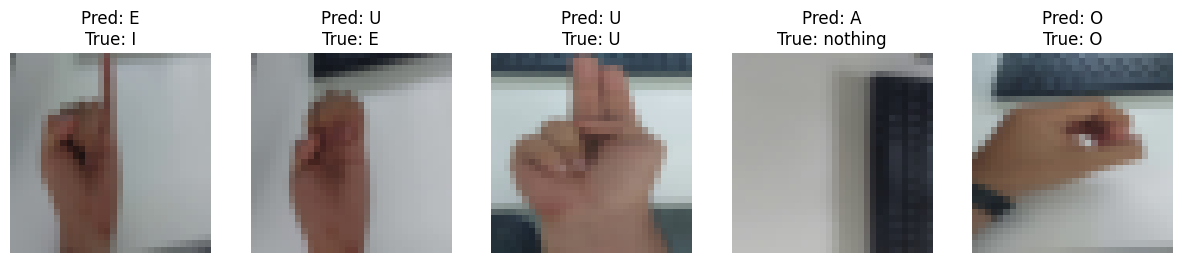

Precisión del bacth: 15
Precisión: 33.11 %
Recall: 0.3750
F1-score: 0.3313


In [67]:
plot_predictions(model, val_propio, batch_ith=15)

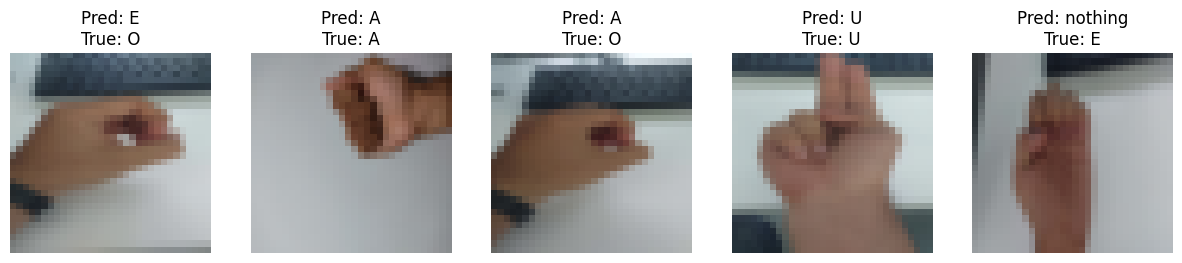

Precisión del bacth: 20
Precisión: 27.59 %
Recall: 0.3750
F1-score: 0.3147


In [83]:
plot_predictions(model, val_propio, batch_ith=20)

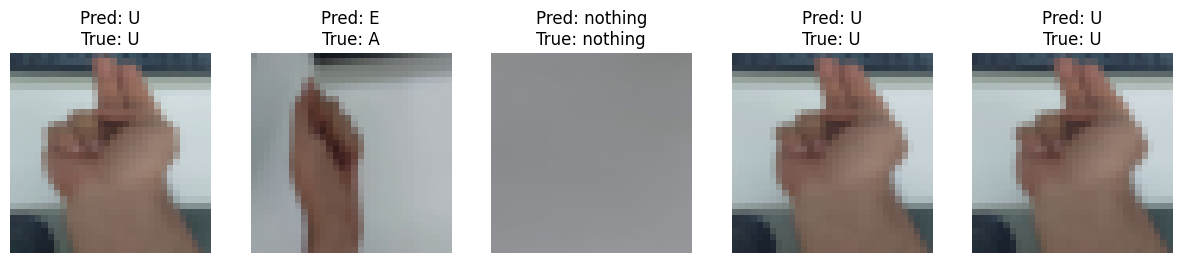

Precisión del bacth: 25
Precisión: 42.61 %
Recall: 0.4219
F1-score: 0.3873


In [69]:
plot_predictions(model, val_propio, batch_ith=25)

## Mejoras y Soluciones para el Módelo
La baja presición en la validación con los datos propios, se debe a la poca variabilidad de los datos de entrenamiento, el aprendizaje se ajustaba muy bien a las imagenes del entrenamiento que tomaba en cuenta caracteristicas adicionales a las señas como la iluminación del fondo, paredes, objetos, bordes de estructuras y demás patrones. Esto afectaba al momento de evaluar el modelo con imagenes diferentes a las del dataset.

Estas matrices se obtienen a partir a partir de los datos de entrenamiento en el archivo `mnist_proyecto_2.ipynb` alojado en el Github, en las imagenes a continuación se puede analizar el comportamiento del modelo cuando se valida:

### Matriz de Confusión con Datos Propios
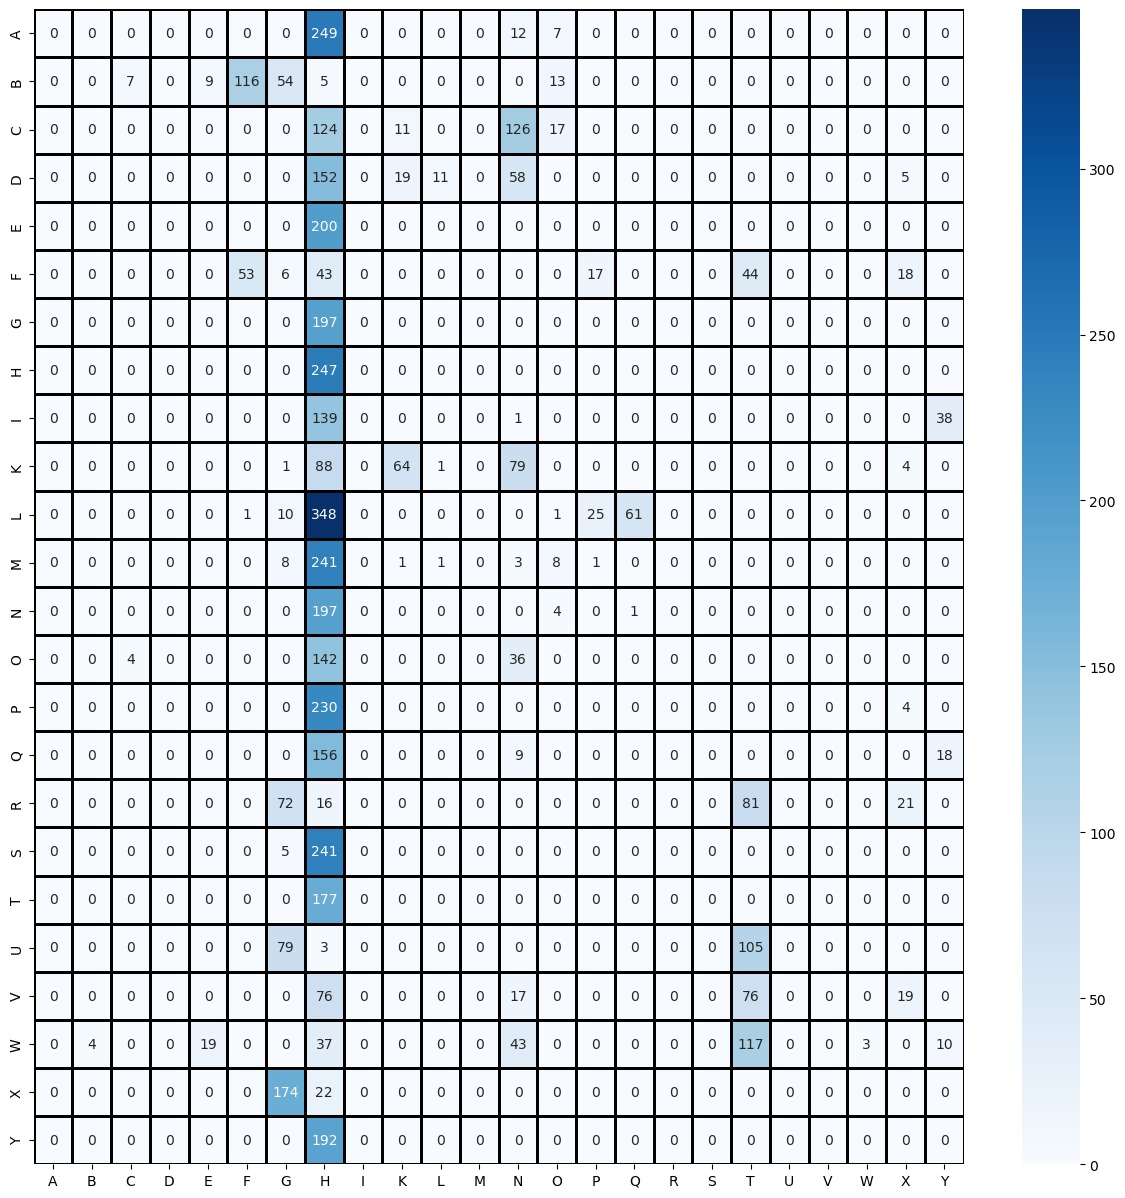
Esta matriz de confusión hace referencia al comportamiento del modelo con los nuestros datos.

### Matriz de Confusión con los Datos de Entrenamiento
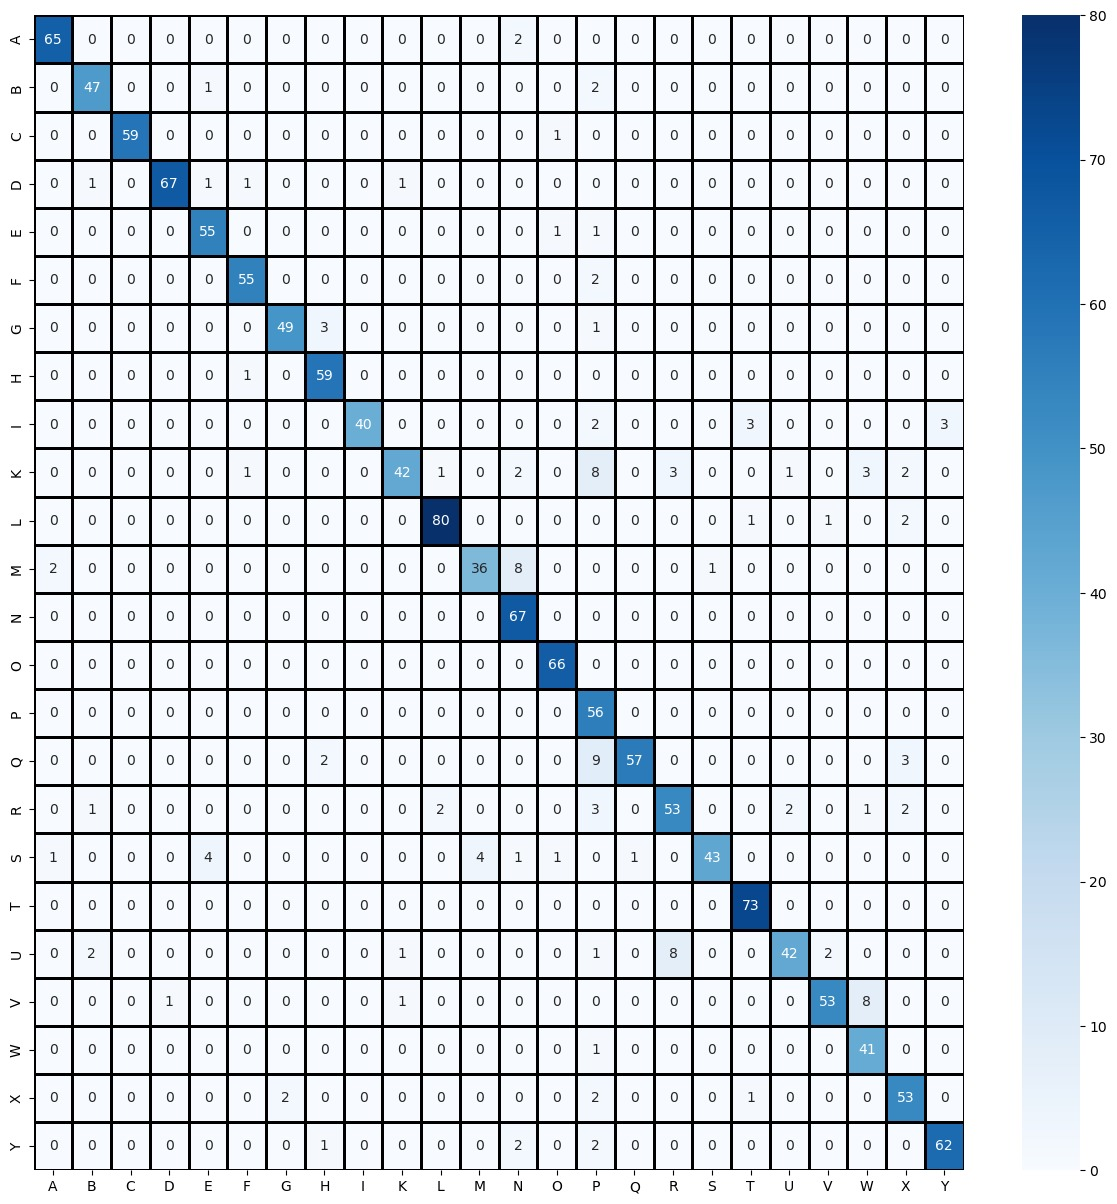
A diferencia de la matriz anterior, esta hace referencia al comportamiento del modelo con los datos de entrenamiento. Por lo que se puede ver un comportamiento alineado a los datos de entrenamiento.


